## Import Libraries

In [42]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## Retrieve Data

In [43]:
# Specify the time period
start_date = '2005-01-01'
end_date = '2025-01-01'

startfile = "assignment_3"

# Use yfinance to retrieve data
symbols = ['SPY', 'TLT', 'VTI']

historical_data = {}

for symbol in symbols:
    ticker = yf.Ticker(symbol)
    data = ticker.history(start='2005-01-01', end='2025-01-01')
    historical_data[symbol] = data
    # Save data to CSV
    data.to_csv(f"{startfile}_{symbol.lower()}.csv")

## Prepare Data

In [44]:
# Combine the data into one df
combined_data = pd.concat(historical_data.values(), keys=historical_data.keys(), axis=1)

#print(combined_data.head())

In [45]:
# Calculate log daily returns
close_df = combined_data.xs('Close', level=1, axis=1)

log_daily_returns = np.log(close_df / close_df.shift(1))

print(log_daily_returns.head())

                                SPY       TLT       VTI
Date                                                   
2005-01-03 00:00:00-05:00       NaN       NaN       NaN
2005-01-04 00:00:00-05:00 -0.012295 -0.010535 -0.013400
2005-01-05 00:00:00-05:00 -0.006925  0.005338 -0.006942
2005-01-06 00:00:00-05:00  0.005071  0.000679  0.004778
2005-01-07 00:00:00-05:00 -0.001435  0.002262 -0.003212


## Implement Clenow Momentum Strategy

In [46]:
# Calculate the 20-day rolling standard deviation for each asset
rolling_volatility = log_daily_returns.rolling(window=20).std()

# Drop rows with NaN values
rolling_volatility = rolling_volatility.dropna()

# Calculate the inverse of the rolling volatility
inverse_volatility = 1 / rolling_volatility.replace([np.inf, -np.inf], np.nan).fillna(0)

# Calculate the sum of inverse volatilities for normalization
sum_inverse_volatility = inverse_volatility.sum(axis=1)

# Normalize the inverse volatilities to get weights that sum to 1
inverse_volatility_weights = inverse_volatility.divide(sum_inverse_volatility, axis=0).fillna(0)

# Store the calculated weights
log_daily_returns_aligned = log_daily_returns.loc[inverse_volatility_weights.index]

for symbol in symbols:
    log_daily_returns_aligned[f'{symbol}_inverse_volatility_weight'] = inverse_volatility_weights[symbol]

#print(log_daily_returns_aligned.head())

## Calculate Momentum

In [47]:
# Calculate momentum (125-day slope of log returns)
momentum_window = 125

# Calculate the rolling slope of the cumulative log returns for each asset
def calculate_rolling_slope(series, window):
    # Calculate cumulative sum of log returns over the rolling window
    rolling_cumulative_returns = series.rolling(window=window).sum()

    # Function to calculate the slope for a given window of data
    def get_slope(data):
        if len(data) < window or np.isnan(data).any():
            return np.nan
        x = np.arange(len(data))
        return np.polyfit(x, data, 1)[0]

    # Apply the get_slope function to the rolling window
    # Use axis=0 to apply the function to each column (asset) over the rolling window (rows)
    return rolling_cumulative_returns.rolling(window=window).apply(get_slope, raw=True)

# Apply the calculate_rolling_slope function to each asset's log daily returns
momentum_slope = log_daily_returns_aligned[symbols].apply(calculate_rolling_slope, axis=0, window=momentum_window)

# Drop rows with NaN values
momentum_slope = momentum_slope.dropna()

print(momentum_slope.head())

                                SPY       TLT       VTI
Date                                                   
2006-01-26 00:00:00-05:00  0.000251 -0.000710  0.000222
2006-01-27 00:00:00-05:00  0.000257 -0.000709  0.000228
2006-01-30 00:00:00-05:00  0.000260 -0.000707  0.000231
2006-01-31 00:00:00-05:00  0.000260 -0.000705  0.000231
2006-02-01 00:00:00-05:00  0.000263 -0.000704  0.000235


## Calculate Trend Filter

In [48]:
# Calculate the 200-day moving average of the S&P 500 (SPY) closing price
spy_close = close_df['SPY']
spy_moving_average_200 = spy_close.rolling(window=200).mean()

# Determine the trend filter: positive if SPY close is above its 200-day moving average
trend_filter = spy_close > spy_moving_average_200

# Align the trend filter with the returns data
trend_filter = trend_filter.loc[log_daily_returns_aligned.index]

print(trend_filter.head())

Date
2005-02-01 00:00:00-05:00    False
2005-02-02 00:00:00-05:00    False
2005-02-03 00:00:00-05:00    False
2005-02-04 00:00:00-05:00    False
2005-02-07 00:00:00-05:00    False
Name: SPY, dtype: bool


## Generate Trading Signals

In [49]:
# Define the minimum required momentum value
min_momentum = 0.0005

# Align trend_filter with momentum_slope index
trend_filter_aligned = trend_filter.loc[momentum_slope.index]

# Generate trading signals based on trend filter and momentum
trading_signals = pd.DataFrame(index=momentum_slope.index)

for symbol in symbols:
    asset_momentum = momentum_slope[symbol]
    # Signal is True if trend filter is positive AND momentum is above the minimum
    trading_signals[symbol] = (trend_filter_aligned) & (asset_momentum > min_momentum)

print(trading_signals.head())

                             SPY    TLT    VTI
Date                                          
2006-01-26 00:00:00-05:00  False  False  False
2006-01-27 00:00:00-05:00  False  False  False
2006-01-30 00:00:00-05:00  False  False  False
2006-01-31 00:00:00-05:00  False  False  False
2006-02-01 00:00:00-05:00  False  False  False


In [50]:
# Apply trading signals to inverse volatility weights
# If signal is True, use the inverse volatility weight; otherwise, the weight is 0 (cash)
portfolio_weights = inverse_volatility_weights.loc[trading_signals.index] * trading_signals

# Normalize weights across selected assets for each day to sum to 1
row_sums = portfolio_weights.sum(axis=1)
portfolio_weights = portfolio_weights.divide(row_sums, axis=0).fillna(0)

print(portfolio_weights.head())

                           SPY  TLT  VTI
Date                                    
2006-01-26 00:00:00-05:00  0.0  0.0  0.0
2006-01-27 00:00:00-05:00  0.0  0.0  0.0
2006-01-30 00:00:00-05:00  0.0  0.0  0.0
2006-01-31 00:00:00-05:00  0.0  0.0  0.0
2006-02-01 00:00:00-05:00  0.0  0.0  0.0


## Backtest Strategy

In [51]:
# Calculate portfolio daily returns
portfolio_daily_returns = (portfolio_weights * log_daily_returns_aligned[symbols]).sum(axis=1)

# Calculate cumulative portfolio returns
cumulative_portfolio_returns = np.exp(portfolio_daily_returns.cumsum())

print(cumulative_portfolio_returns.head())

Date
2005-02-01 00:00:00-05:00    1.0
2005-02-02 00:00:00-05:00    1.0
2005-02-03 00:00:00-05:00    1.0
2005-02-04 00:00:00-05:00    1.0
2005-02-07 00:00:00-05:00    1.0
dtype: float64


## Implement Monthly Rebalancing

In [52]:
# Resample weights to monthly frequency and forward fill to maintain weights throughout the month
monthly_portfolio_weights = portfolio_weights.resample('M').first()
monthly_portfolio_weights = monthly_portfolio_weights.reindex(portfolio_weights.index, method='ffill')

# Ensure weights are still normalized to 1 each day after rebalancing
row_sums_monthly = monthly_portfolio_weights.sum(axis=1)
monthly_portfolio_weights = monthly_portfolio_weights.divide(row_sums_monthly, axis=0).fillna(0)

# Replace the daily portfolio_weights with the monthly rebalanced weights
portfolio_weights = monthly_portfolio_weights

print(portfolio_weights.head())

                           SPY  TLT  VTI
Date                                    
2006-01-26 00:00:00-05:00  0.0  0.0  0.0
2006-01-27 00:00:00-05:00  0.0  0.0  0.0
2006-01-30 00:00:00-05:00  0.0  0.0  0.0
2006-01-31 00:00:00-05:00  0.0  0.0  0.0
2006-02-01 00:00:00-05:00  0.0  0.0  0.0


## Evaluate Performance

Total Return: 1.1355
Annualized Return: 0.0388
Annualized Volatility: 0.0862
Sharpe Ratio: 0.4503
Maximum Drawdown: 0.0892


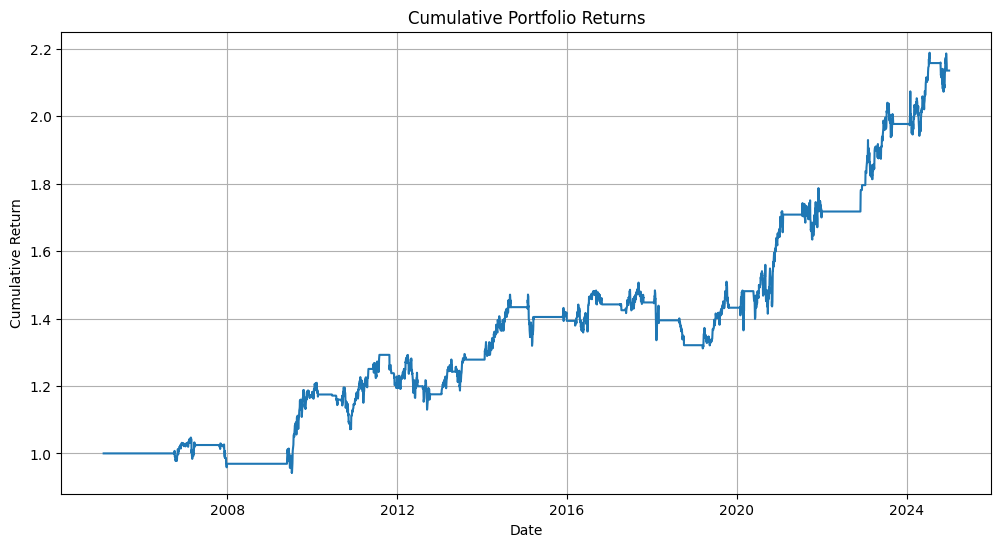

In [53]:
# Total Return
total_return = cumulative_portfolio_returns.iloc[-1] - 1

# Annualized Return (assuming daily data and 252 trading days in a year)
# Calculate the number of years
years = (cumulative_portfolio_returns.index[-1] - cumulative_portfolio_returns.index[0]).days / 365.25
annualized_return = (1 + total_return)**(1/years) - 1

# Annualized Volatility
annualized_volatility = portfolio_daily_returns.std() * np.sqrt(252)

# Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
sharpe_ratio = annualized_return / annualized_volatility

# Maximum Drawdown
# Calculate the running maximum
running_max = cumulative_portfolio_returns.cummax()
# Calculate the drawdown
drawdown = running_max - cumulative_portfolio_returns
# Calculate the maximum drawdown
max_drawdown = drawdown.max() / running_max.max()


print(f"Total Return: {total_return:.4f}")
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Annualized Volatility: {annualized_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_portfolio_returns)
plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

## Use QQQ as a Comparison Metric

In [54]:
qqq_data = yf.Ticker('QQQ').history(start=start_date, end=end_date)

In [55]:
#display(qqq_data.head())

In [56]:
qqq_returns = np.log(qqq_data['Close'] / qqq_data['Close'].shift(1))
qqq_returns = qqq_returns.dropna()
display(qqq_returns.head())

,Close
Date,
2005-01-04 00:00:00-05:00,-0.018396
2005-01-05 00:00:00-05:00,-0.006208
2005-01-06 00:00:00-05:00,-0.004942
2005-01-07 00:00:00-05:00,0.005202
2005-01-10 00:00:00-05:00,-0.000520


## Compare Sharpe Ratios

In [57]:
# Calculate Annualized Volatility for QQQ
qqq_annualized_volatility = qqq_returns.std() * np.sqrt(252)

# Calculate Annualized Return for QQQ
# Align QQQ returns with the portfolio's cumulative returns index for a comparable time frame
qqq_returns_aligned = qqq_returns.loc[cumulative_portfolio_returns.index]
qqq_total_return_aligned = np.exp(qqq_returns_aligned.sum()) - 1
qqq_years_aligned = (qqq_returns_aligned.index[-1] - qqq_returns_aligned.index[0]).days / 365.25
qqq_annualized_return = (1 + qqq_total_return_aligned)**(1/qqq_years_aligned) - 1

# Calculate Sharpe Ratio for QQQ
qqq_sharpe_ratio = qqq_annualized_return / qqq_annualized_volatility

print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"QQQ Sharpe Ratio: {qqq_sharpe_ratio:.4f}")

Portfolio Sharpe Ratio: 0.4503
QQQ Sharpe Ratio: 0.6918


In [58]:
# Calculate Maximum Drawdown for QQQ
# Calculate the running maximum for QQQ cumulative returns
qqq_running_max = cumulative_qqq_returns.cummax()
# Calculate the drawdown for QQQ
qqq_drawdown = qqq_running_max - cumulative_qqq_returns
# Calculate the maximum drawdown for QQQ
qqq_max_drawdown = qqq_drawdown.max() / qqq_running_max.max()

print(f"Portfolio Maximum Drawdown: {max_drawdown:.4f}")
print(f"QQQ Maximum Drawdown: {qqq_max_drawdown:.4f}")

Portfolio Maximum Drawdown: 0.0892
QQQ Maximum Drawdown: 0.2585


## Compare to QQQ Benchmark

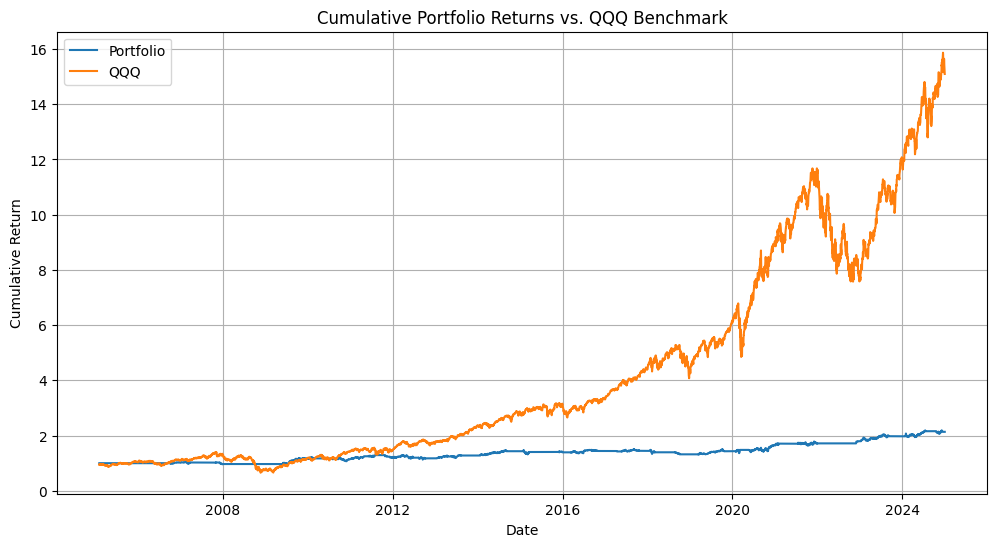

In [59]:
# Calculate cumulative QQQ returns
cumulative_qqq_returns = np.exp(qqq_returns.cumsum())

# Align the cumulative returns dataframes by index
aligned_cumulative_returns = pd.concat([cumulative_portfolio_returns, cumulative_qqq_returns], axis=1).dropna()
aligned_cumulative_returns.columns = ['Portfolio', 'QQQ']

# Plot cumulative returns for both the portfolio and QQQ
plt.figure(figsize=(12, 6))
plt.plot(aligned_cumulative_returns['Portfolio'], label='Portfolio')
plt.plot(aligned_cumulative_returns['QQQ'], label='QQQ')
plt.title('Cumulative Portfolio Returns vs. QQQ Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()